## 正侧视RD算法

### 三点回波模拟

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

from numpy import pi,abs,max,min,argmax,argmin,ceil,exp,sqrt,real,imag,conj,sinc,sin,cos,tan,arctan,angle,unwrap
from numpy import linspace,arange,zeros,ones,concatenate
from numpy.fft import fft,fftshift,ifft,ifftshift,fft2
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout

In [2]:
c=3e8;       #光速       
f0=10e9;        #雷达工作频率
lamd=c/f0;     #雷达工作波长     
Tp=1e-6;        #
B=100e6;         #  
PRF=3600;        #脉冲重复频率 
fs=120e6;          #
K=B/Tp;            #

v=150;          #等效雷达运动速度

x1=0;y1=0;      #目标1位置         
x2=0;y2=-50;        #目标2位置
x3=0;y3=50;    #目标3位置

Na=4096;    # 方位向采样点数为4096
bet=18/180*pi;      #
R0=1000;            

Nr=256;             
Tr=Nr/fs;           
Ta=Na/PRF;          

tr=2*R0/c+linspace(-Tr/2,Tr/2,Nr);   
ta=linspace(-Ta/2,Ta/2,Na);          
xr=v*ta;                             
yr=R0;                               
fr=fftshift(linspace(-fs/2,fs/2,Nr));       
fa=linspace(-PRF/2,PRF/2,Na);                
r=tr*c/2;                                    
r_c=sqrt(xr**2+yr**2);

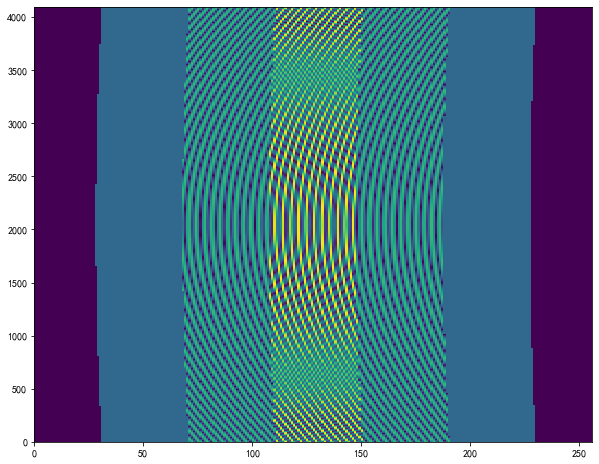

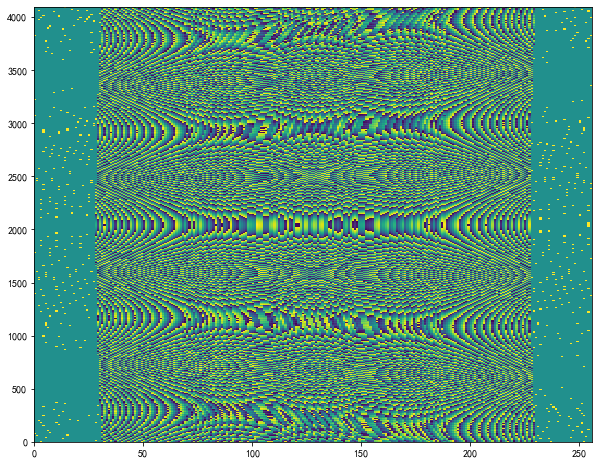

In [4]:
#====================================产生回波===============================

rec_signal = zeros((Na,Nr),dtype='complex');
for i in range(Na):
    puls_signal=zeros(Nr);                     
    r1=sqrt((y1+yr)**2+(xr[i]-x1)**2);           
    cita1=arctan(abs(x1-xr[i])/(yr+y1));           
    if (abs(cita1)<bet/2):
        puls_signal=exp(1j*(pi*K*(tr-2*r1/c)**2-2*pi*f0*2*r1/c))*np.where(abs(tr-2*r1/c)<Tp/2,1,0);   
    
    r2=sqrt((y2+yr)**2+(xr[i]-x2)**2);           
    cita2=arctan(abs(x2-xr[i])/(yr+y2));          
    if (abs(cita2)<bet/2):
        puls_signal=puls_signal+exp(1j*(pi*K*(tr-2*r2/c)**2-2*pi*f0*2*r2/c))*np.where(abs(tr-2*r2/c)<Tp/2,1,0);#目标2回波
    
    r3=sqrt((y3+yr)**2+(xr[i]-x3)**2);          
    cita3=arctan(abs(x3-xr[i])/(yr+y3));          
    if (abs(cita3)<bet/2):
        puls_signal=puls_signal+exp(1j*(pi*K*(tr-2*r3/c)**2-2*pi*f0*2*r3/c))*np.where(abs(tr-2*r3/c)<Tp/2,1,0);#目标3回波
    
    rec_signal[[i],:]=puls_signal;
figure(figsize=(10,8));
plt.pcolor(abs(rec_signal));
figure(figsize=(10,8));
plt.pcolor(angle(rec_signal));

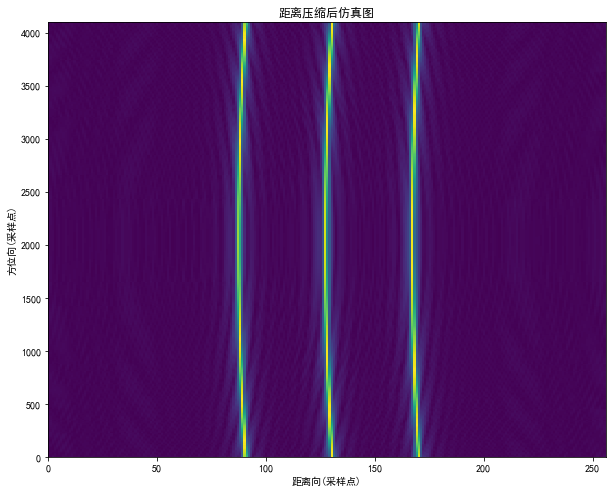

In [5]:
#================================距离向脉压=================================

tran_signal=exp(1j*pi*fr**2/K);      #.*(abs(fr)<B/2); 这个范围限制最好要有，但为了方便改写C语言，不要范围图像也还可以，真正的改写要加上此范围
for i in range(Na):
    t = fft(rec_signal[i,:]);
    tt =t *tran_signal;
    rec_signal[[i],:]=ifft(tt);

figure(figsize=(10,8));
plt.pcolor(abs(rec_signal));
title('距离压缩后仿真图');
xlabel('距离向(采样点)');
ylabel('方位向(采样点)');

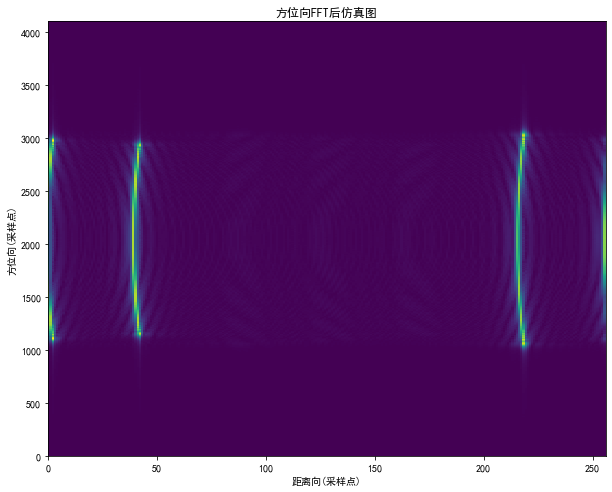

In [6]:
#==============================插值法消除距离徙动===========================
# signal_fft  = fft(rec_signal,axis=0);
signal_fft  = fft(rec_signal,axis=0);
rec_signal1=fftshift(signal_fft);    #方位向变为频域
# rec_signal=fft(rec_signal,[],1);
# #方位向变为频域，只方位向FFT不行，需要FFT后进行fftshift操作

figure(figsize=(10,8));
plt.pcolor(abs(rec_signal1));
title('方位向FFT后仿真图');
xlabel('距离向(采样点)');
ylabel('方位向(采样点)');

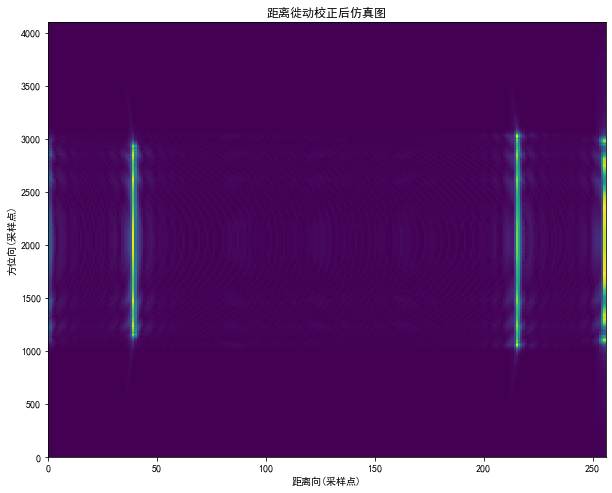

In [17]:
from scipy.interpolate import interp1d, splrep, splev
for i in range(Na):
    delt_r=lamd**2*R0*fa[i]**2/8/v**2;
#     print( delt_r )
#     rec_signal[[i],:]=interp1(r,rec_signal1[i,:],r+delt_r[i],'nearest');  #插值  分段线性插值 linear   球面插值spline   三次多项式插值pchip   临近插值nearest
    rec_signal[[i],:]=interp1d(r,rec_signal1[i,:],fill_value="extrapolate")(r+delt_r);  #插值  分段线性插值 linear   球面插值spline   三次多项式插值pchip   临近插值nearest


figure(figsize=(10,8));
rec_signal_abs = abs(rec_signal);
plt.pcolor(abs(rec_signal));
title('距离徙动校正后仿真图');
xlabel('距离向(采样点)');
ylabel('方位向(采样点)');

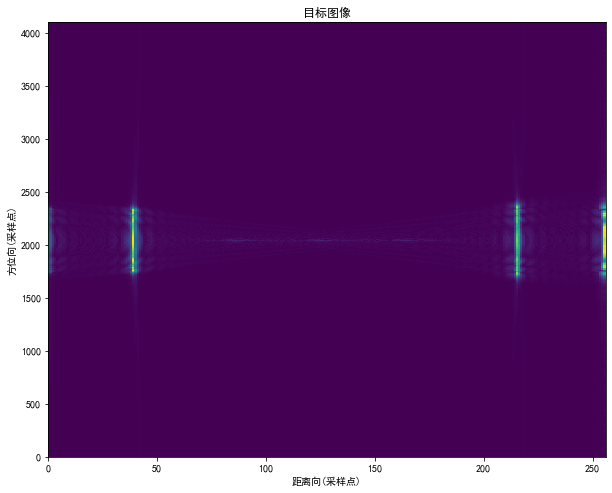

In [20]:
#================================方位向进行脉压===========================
# #{
# for ii in range(Nr):
#     Ka=2*v**2/lamd/r[ii];
#     puls_a=exp(-1j*pi*fa**2/Ka)*np.where(abs(fa)<Ka*Ta/2,1,0);
#     rec_signal[ii,:]=ifft(rec_signal[ii,:]*puls_a);

# #}
#以下为降低方位向旁瓣 18°可按照大斜视角做
rec_signal2=zeros((Na,Nr),dtype='complex');
for ii in range(Nr):
    Ka=sqrt( 1-(lamd**2.*fa**2) / ( 4*(v**2) )  );
    theta = 2*pi*tr[ii]*f0*Ka;
    puls_a=exp(1j*2*pi*tr[ii]*f0*Ka);
    rec_signal1[:,ii] =  rec_signal[:,ii]*puls_a;
    rec_signal2[:,ii]=ifft(rec_signal1[:,ii]);


figure(figsize=(10,8));
# colormap(gray);
rec_signal2_abs = abs(rec_signal2);
plt.pcolor(abs(rec_signal2));
title('目标图像');
xlabel('距离向(采样点)');
ylabel('方位向(采样点)');

https://blog.csdn.net/qq_41640675/article/details/108445568